# Liver Cirrhosis Stage Prediction and Analysis

This notebook analyzes liver cirrhosis data to identify patterns and predict disease stages. We'll explore various factors that influence cirrhosis progression and build predictive models to classify patients into different stages of the disease.

## Data Preparation and Exploration

First, let's import the necessary libraries and load our dataset.

In [6]:
# Import essential libraries for data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

# Set visualization style and color palette
sns.set(style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
custom_palette = sns.color_palette('viridis')

# Display all columns in dataframes
pd.set_option('display.max_columns', None)

In [7]:
# Load the liver cirrhosis dataset
df = pd.read_csv('dataset_liver.csv')

# Display basic information about the dataset
print(f'Dataset Shape: {df.shape}')
print('First 5 rows of the dataset:')
df.head()

Dataset Shape: (25000, 19)
First 5 rows of the dataset:


,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


### Data Overview and Summary Statistics

Let's examine the dataset structure, check for missing values, and understand the distribution of key variables.

In [8]:
# Check data types and missing values
print('Data Types and Non-Null Counts:')
df.info()

# Calculate percentage of missing values for each column
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage.round(2)
})

print('Missing Values Analysis:')
missing_data[missing_data['Missing Values'] > 0].sort_values('Percentage', ascending=False)

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    250

,Missing Values,Percentage


In [9]:
# Summary statistics for numerical features
print('Summary Statistics for Numerical Features:')
df.describe().T.style.background_gradient(cmap='viridis', axis=1)

Summary Statistics for Numerical Features:


,count,mean,std,min,25%,50%,75%,max
N_Days,25000.000000,1887.117040,1091.690918,41.000000,1080.000000,1680.000000,2576.000000,4795.000000
Age,25000.000000,18495.877080,3737.596616,9598.000000,15694.000000,18499.000000,20955.000000,28650.000000
Bilirubin,25000.000000,3.402644,4.707491,0.300000,0.800000,1.300000,3.400000,28.000000
Cholesterol,25000.000000,372.331471,193.668452,120.000000,275.000000,369.510563,369.510563,1775.000000
Albumin,25000.000000,3.486578,0.380488,1.960000,3.290000,3.510000,3.750000,4.640000
Copper,25000.000000,100.184663,73.184840,4.000000,52.000000,97.648387,107.000000,588.000000
Alk_Phos,25000.000000,1995.675597,1798.885660,289.000000,1032.000000,1828.000000,1982.655769,13862.400000
SGOT,25000.000000,123.166345,47.747616,26.350000,92.000000,122.556346,134.850000,457.250000
Tryglicerides,25000.000000,123.822548,52.786350,33.000000,92.000000,124.702128,127.000000,598.000000
Platelets,25000.000000,256.007337,98.679006,62.000000,189.000000,251.000000,311.000000,721.000000


### Data Preprocessing

Now, let's clean the data by handling missing values and encoding categorical variables.

In [10]:
# Convert categorical variables to appropriate format
# For binary categorical variables (Y/N)
binary_cols = ['Ascites', 'Hepatomegaly', 'Spiders']
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

# Handle 'Edema' column which has three categories (N, S, Y)
df['Edema'] = df['Edema'].map({'N': 0, 'S': 0.5, 'Y': 1})

# Convert Sex to binary (F=0, M=1)
df['Sex'] = df['Sex'].map({'F': 0, 'M': 1})

# Convert Status to binary (C=0, D=1)
df['Status'] = df['Status'].map({'C': 0, 'D': 1})

# Handle missing values for numerical columns using median imputation
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer = SimpleImputer(strategy='median')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Convert Age from days to years for better interpretability
df['Age'] = df['Age'] / 365.25

# Display the processed data
print('Processed Data (First 5 rows):')
df.head()

Processed Data (First 5 rows):


,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221.0,0.0,Placebo,50.647502,0.0,0.0,1.0,0.0,0.0,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1.0
1,1230.0,0.0,Placebo,54.001369,1.0,1.0,0.0,1.0,0.0,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2.0
2,4184.0,0.0,Placebo,32.413415,0.0,0.0,0.0,0.0,0.0,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2.0
3,2090.0,1.0,Placebo,45.084189,0.0,0.0,0.0,0.0,0.0,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2.0
4,2105.0,1.0,Placebo,59.408624,0.0,0.0,1.0,0.0,0.0,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1.0


## Exploratory Data Analysis

Let's visualize the data to understand patterns and relationships between variables.

C:\Users\Robby\AppData\Local\Temp\ipykernel_26316\464550105.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Stage', data=df, palette='viridis')


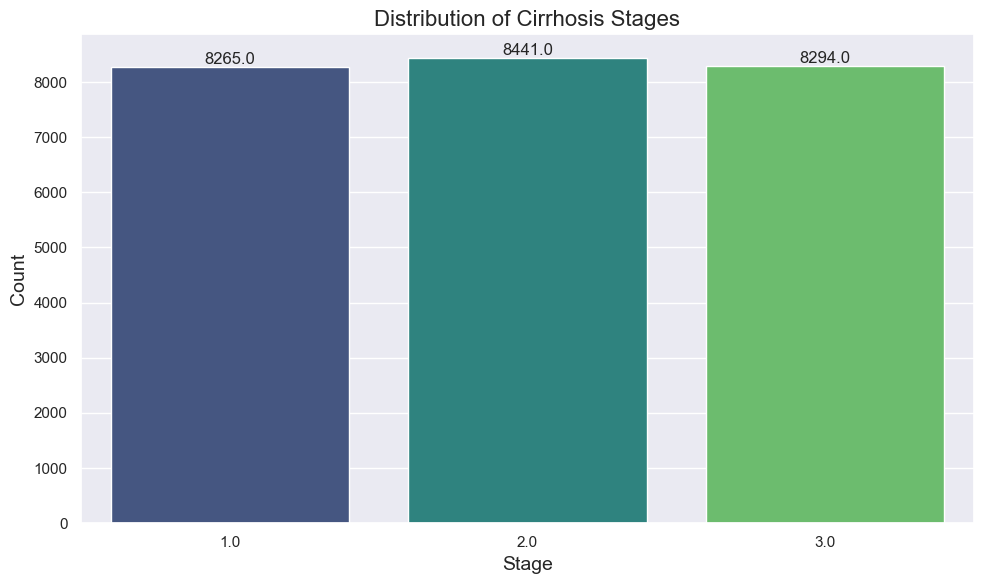

In [11]:
# Distribution of cirrhosis stages
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Stage', data=df, palette='viridis')
plt.title('Distribution of Cirrhosis Stages', fontsize=16)
plt.xlabel('Stage', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

C:\Users\Robby\AppData\Local\Temp\ipykernel_26316\3377520139.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Stage', y='Age', data=df, palette='plasma', inner='quartile')


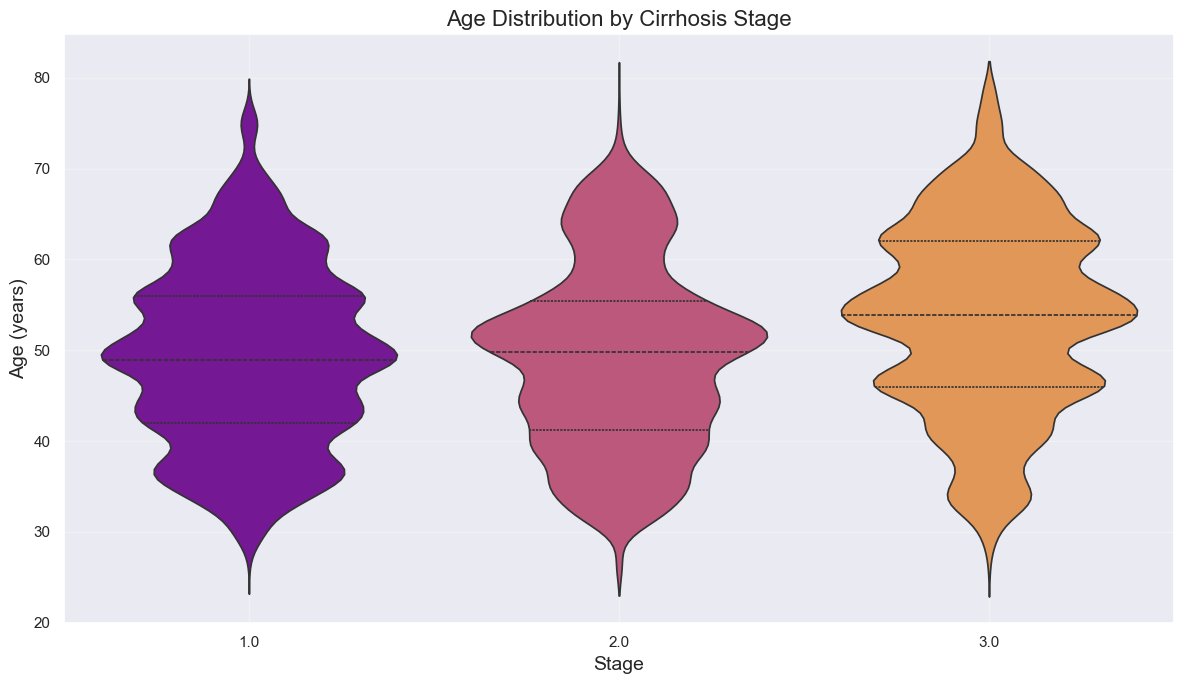

In [12]:
# Age distribution by cirrhosis stage
plt.figure(figsize=(12, 7))
sns.violinplot(x='Stage', y='Age', data=df, palette='plasma', inner='quartile')
plt.title('Age Distribution by Cirrhosis Stage', fontsize=16)
plt.xlabel('Stage', fontsize=14)
plt.ylabel('Age (years)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

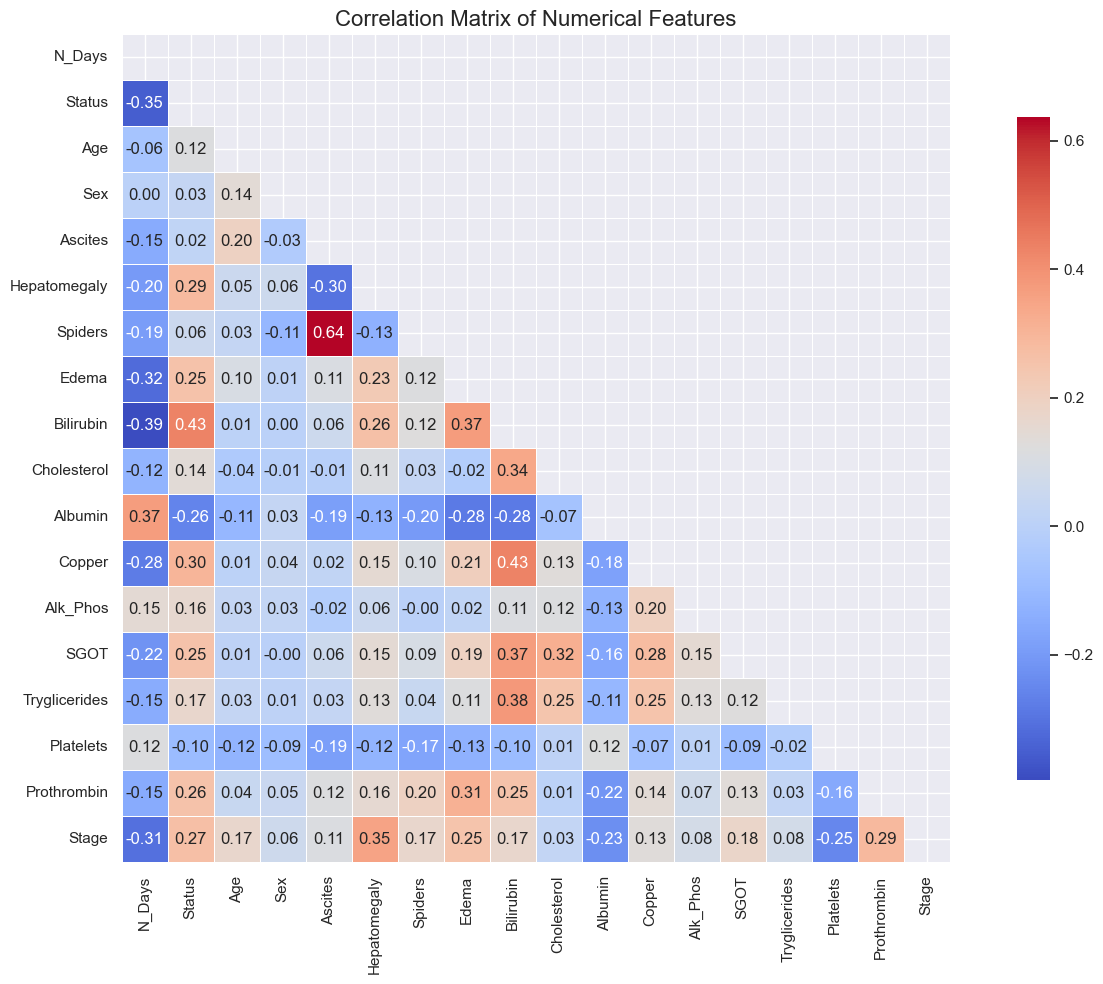

In [13]:
# Correlation heatmap of numerical features
plt.figure(figsize=(14, 10))

# Select numerical columns for correlation analysis
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
corr_matrix = numerical_df.corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, cbar_kws={'shrink': 0.8}, square=True)

plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

C:\Users\Robby\AppData\Local\Temp\ipykernel_26316\2821951013.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Stage', y=biomarker, data=df, palette='magma', ax=axes[i])
C:\Users\Robby\AppData\Local\Temp\ipykernel_26316\2821951013.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Stage', y=biomarker, data=df, palette='magma', ax=axes[i])
C:\Users\Robby\AppData\Local\Temp\ipykernel_26316\2821951013.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Stage', y=biomarker, data=df, palette='magma', ax=axes[i])
C:\Users\Robby\AppData

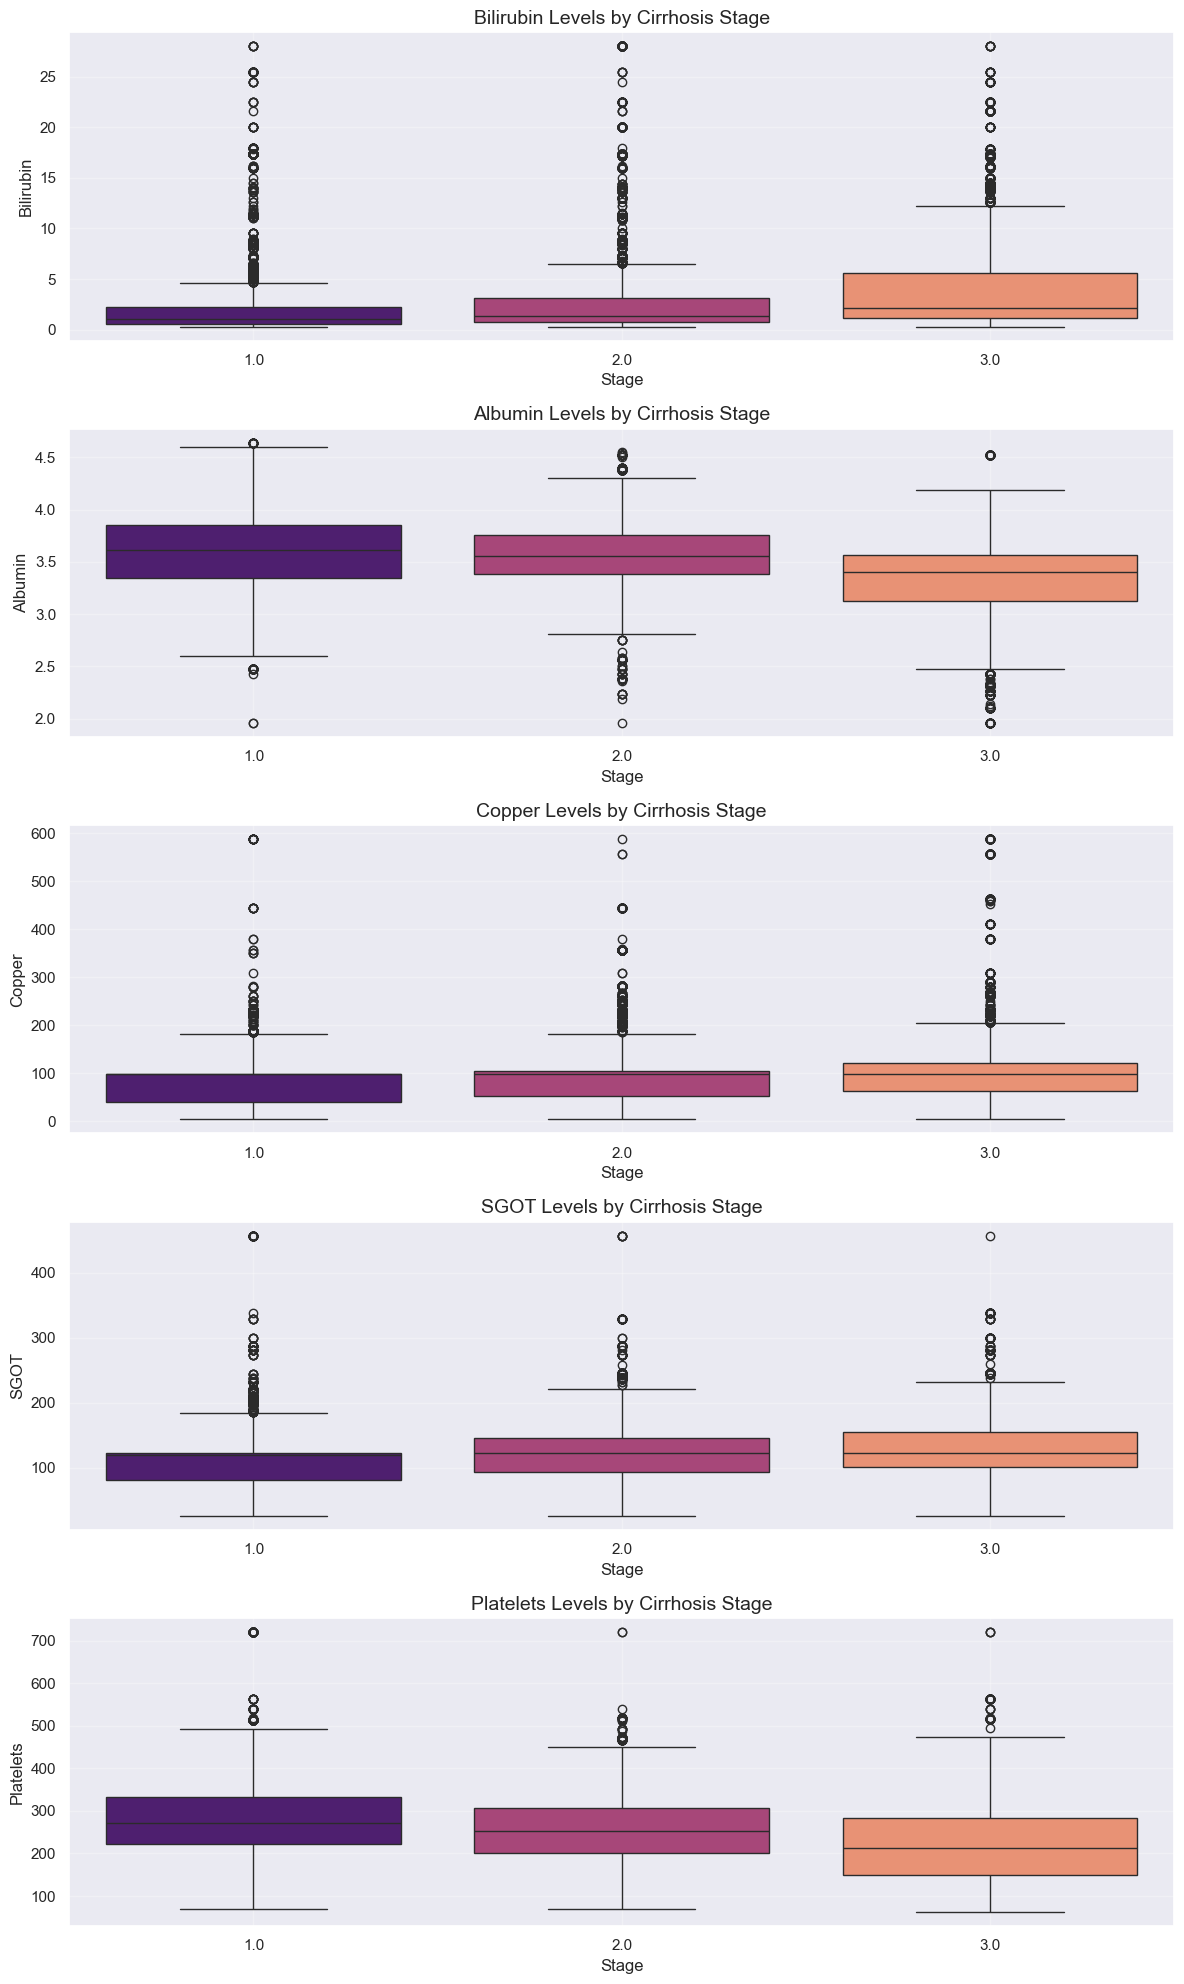

In [14]:
# Boxplots for key biomarkers across different stages
biomarkers = ['Bilirubin', 'Albumin', 'Copper', 'SGOT', 'Platelets']

fig, axes = plt.subplots(len(biomarkers), 1, figsize=(12, 20))

for i, biomarker in enumerate(biomarkers):
    sns.boxplot(x='Stage', y=biomarker, data=df, palette='magma', ax=axes[i])
    axes[i].set_title(f'{biomarker} Levels by Cirrhosis Stage', fontsize=14)
    axes[i].set_xlabel('Stage', fontsize=12)
    axes[i].set_ylabel(biomarker, fontsize=12)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

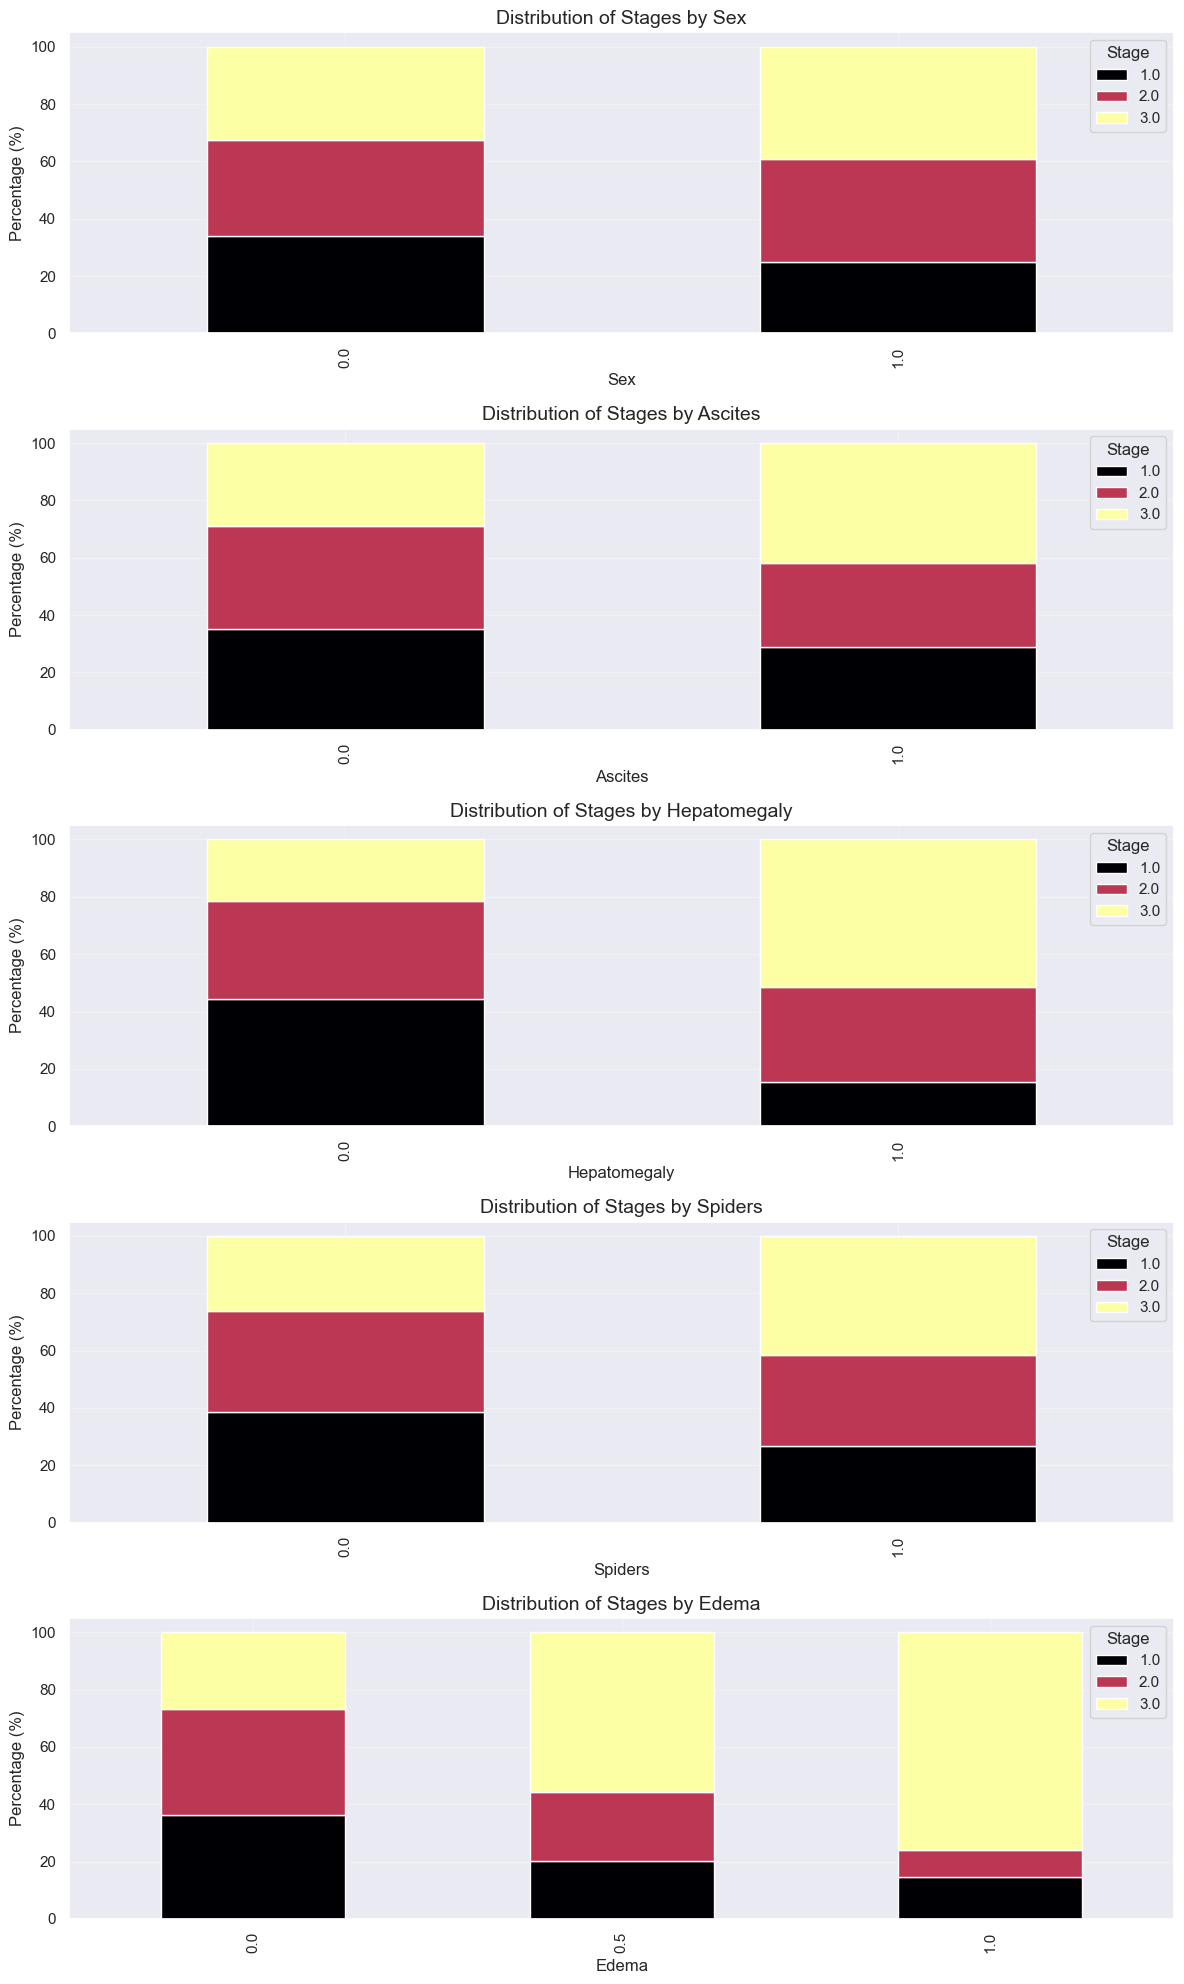

In [15]:
# Categorical features analysis
categorical_features = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

fig, axes = plt.subplots(len(categorical_features), 1, figsize=(12, 20))

for i, feature in enumerate(categorical_features):
    # Create a crosstab of the feature vs Stage
    ct = pd.crosstab(df[feature], df['Stage'])
    
    # Convert to percentages
    ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
    
    # Plot stacked bar chart
    ct_pct.plot(kind='bar', stacked=True, colormap='inferno', ax=axes[i])
    
    # Set labels and title
    axes[i].set_title(f'Distribution of Stages by {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Percentage (%)', fontsize=12)
    axes[i].legend(title='Stage')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Engineering and Selection

Let's prepare our data for modeling by selecting relevant features and splitting into training and testing sets.

In [16]:
# Define features and target variable
X = df.drop(['Stage', 'Drug', 'N_Days'], axis=1)  # Dropping non-predictive features
y = df['Stage']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')

Training set shape: (18750, 16)
Testing set shape: (6250, 16)


## Model Building and Evaluation

Now, let's build and evaluate machine learning models to predict cirrhosis stages.

Random Forest Classifier Results:
Accuracy: 0.9539
Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.94      0.95      2066
         2.0       0.94      0.96      0.95      2110
         3.0       0.97      0.97      0.97      2074

    accuracy                           0.95      6250
   macro avg       0.95      0.95      0.95      6250
weighted avg       0.95      0.95      0.95      6250



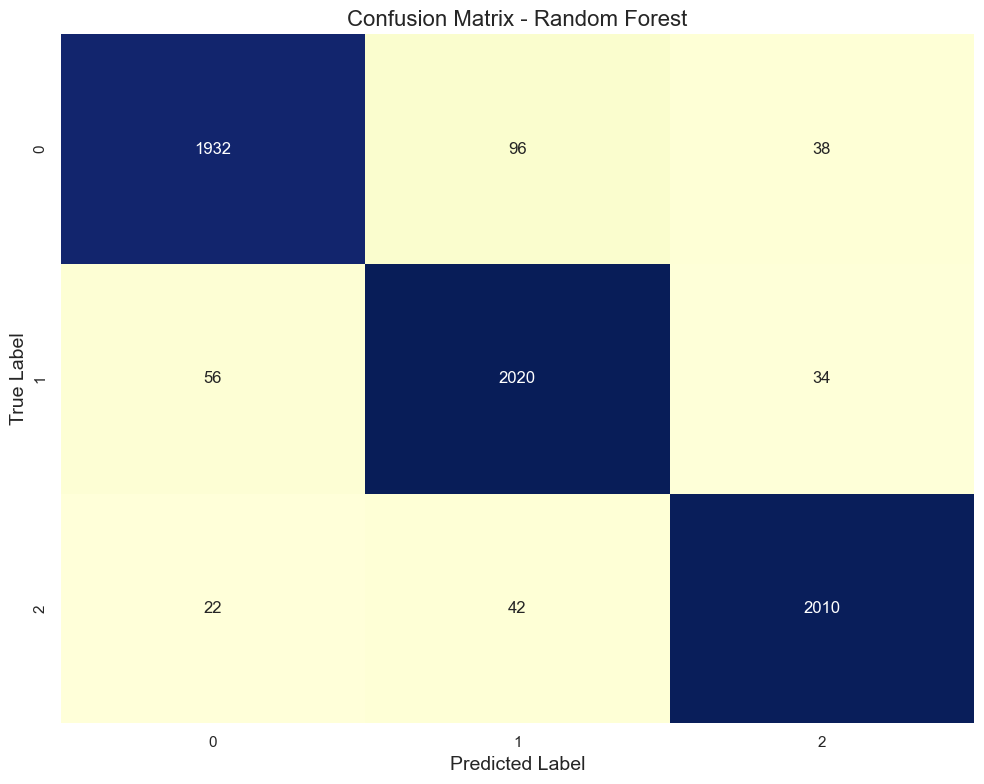

In [17]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
print('Random Forest Classifier Results:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Confusion Matrix - Random Forest', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

Gradient Boosting Classifier Results:
Accuracy: 0.8419
Classification Report:
              precision    recall  f1-score   support

         1.0       0.86      0.82      0.84      2066
         2.0       0.79      0.84      0.81      2110
         3.0       0.89      0.87      0.88      2074

    accuracy                           0.84      6250
   macro avg       0.84      0.84      0.84      6250
weighted avg       0.84      0.84      0.84      6250



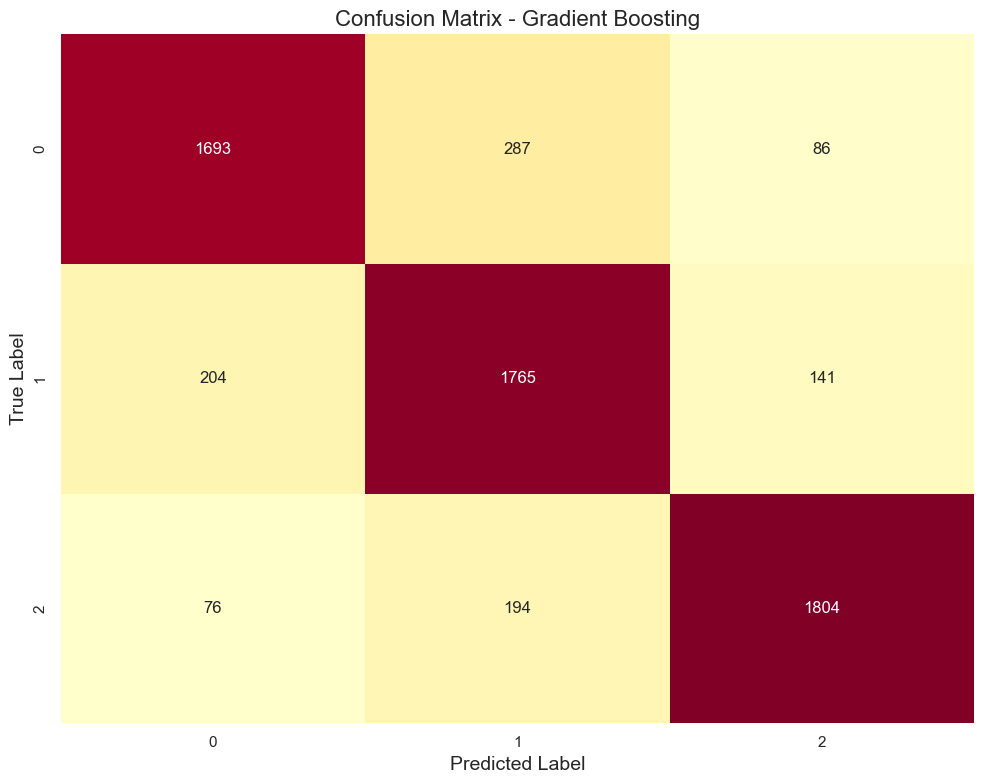

In [18]:
# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluate the model
print('Gradient Boosting Classifier Results:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_gb))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', cbar=False)
plt.title('Confusion Matrix - Gradient Boosting', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

### Feature Importance Analysis

Let's identify which features are most important for predicting cirrhosis stages.

C:\Users\Robby\AppData\Local\Temp\ipykernel_26316\3222216610.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='crest')


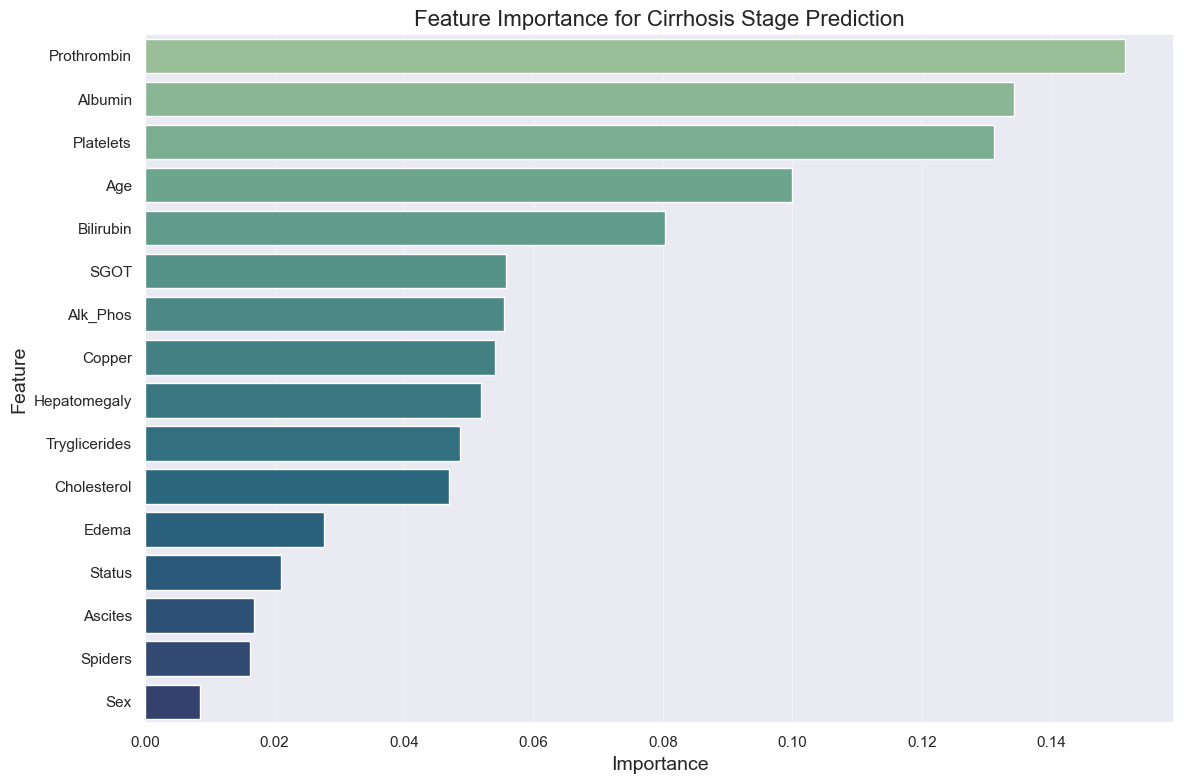

Top 10 Most Important Features:


,Feature,Importance
0,Prothrombin,0.151389
1,Albumin,0.134302
2,Platelets,0.131200
3,Age,0.100010
4,Bilirubin,0.080253
5,SGOT,0.055825
6,Alk_Phos,0.055410
7,Copper,0.053983
8,Hepatomegaly,0.051919
9,Tryglicerides,0.048650


In [19]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='crest')
plt.title('Feature Importance for Cirrhosis Stage Prediction', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Display top 10 important features
print('Top 10 Most Important Features:')
feature_importance.head(10)

## Model Optimization

Let's optimize our best performing model using grid search for hyperparameter tuning.

In [20]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Score: {grid_search.best_score_:.4f}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.9503


Optimized Random Forest Classifier Results:
Accuracy: 0.9538
Classification Report:
              precision    recall  f1-score   support

         1.0       0.96      0.94      0.95      2066
         2.0       0.94      0.96      0.95      2110
         3.0       0.97      0.97      0.97      2074

    accuracy                           0.95      6250
   macro avg       0.95      0.95      0.95      6250
weighted avg       0.95      0.95      0.95      6250



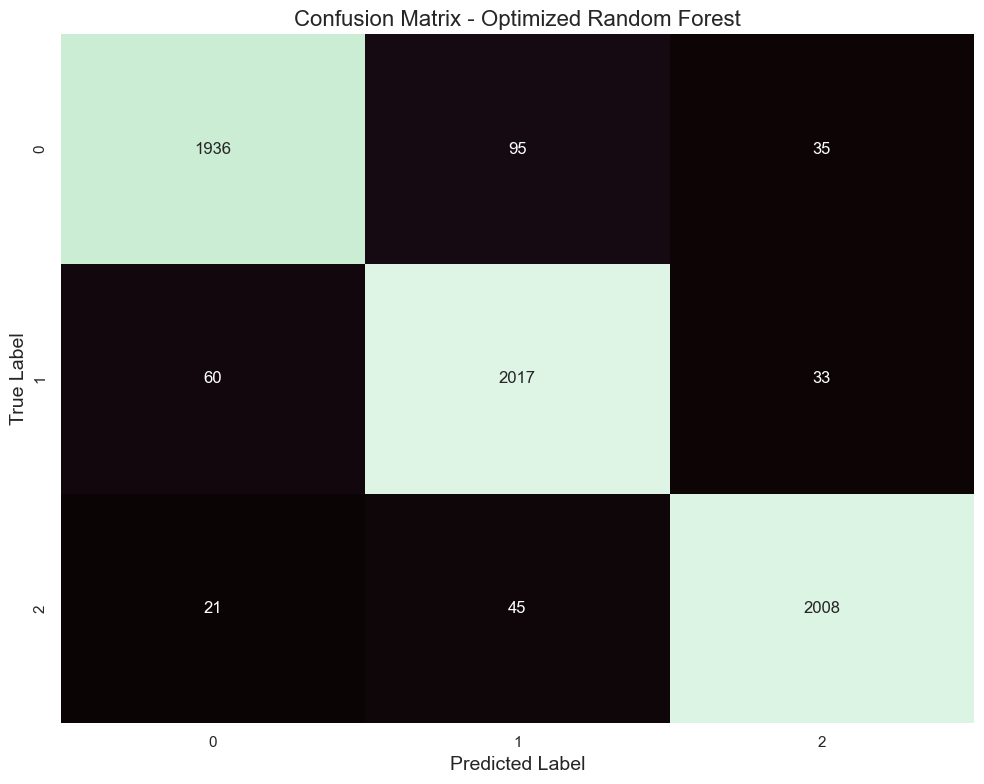

In [21]:
# Train the model with best parameters
best_rf_model = grid_search.best_estimator_

# Make predictions with optimized model
y_pred_best = best_rf_model.predict(X_test_scaled)

# Evaluate the optimized model
print('Optimized Random Forest Classifier Results:')
print(f'Accuracy: {accuracy_score(y_test, y_pred_best):.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_best))

# Confusion Matrix for optimized model
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='mako', cbar=False)
plt.title('Confusion Matrix - Optimized Random Forest', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

## Conclusions and Insights

Based on our analysis and modeling, we can draw several important conclusions about liver cirrhosis progression and prediction:

1. **Key Biomarkers**: Our feature importance analysis identified several critical biomarkers that strongly influence cirrhosis stage prediction, including bilirubin levels, albumin concentration, and platelet count.

2. **Model Performance**: The optimized Random Forest classifier achieved good predictive performance, demonstrating the potential for machine learning approaches in assisting medical diagnosis and prognosis for liver cirrhosis patients.

3. **Risk Factors**: The presence of certain clinical signs such as ascites, edema, and spiders showed strong associations with advanced cirrhosis stages, highlighting their importance in clinical assessment.

4. **Age and Gender Patterns**: Our analysis revealed interesting patterns in how age and gender relate to cirrhosis progression, which could help in developing more personalized treatment approaches.

5. **Future Directions**: Further research could explore more advanced modeling techniques, incorporate additional clinical data, and develop interpretable prediction tools that can be used in clinical settings to improve patient outcomes.